# Summary and Important Functions

This jupyter notebook contains a simulation on how profit/loss for a given UniswapV3 with respect to a 
liquidity position, a given time period, and a fixed daily fee collection. Examples on how to use it is below.  


## Use Case 1. - Simulating Price Action

This can be used to give a estimate on the bounds of a UniswapV3 LP position with respect to volatility, price range
and time to LP. Below is an example of a price distribution for weth during a 30 day period taken from the historical eth price. Copy and run the code in a python cell after running all the cells below. 


#### 1. Get Table
Price = Table.read_table(path)

#### 2. Make Correct Price Table with daily change percentage
Price_Vol = priceTable(Price)

#3. Run simulation_results. This gives a distribution of possible price action after running 
#### simulations. 

#simulation_results(table,boostrap,iterations,start_price,days,vol):
#### table - Price_Vol Table is needed
#### boostrap - True or False - bootstrap the data 
#### iterations - Number 
#### days - the time period for a certian number of days 
#### vol - value between 0-1 that dampens volalitily. 0 is no volatility and 1 is natural volitality 

simulation_results(Price_Vol,True,10000,1317,30,1)

# Use Case 2. - Simulating LPing Profits and Loss


The function $simulate_experiment$ experiment can be used to simulate the gains/losses for an LP position in uniswapV3 over a user defined time period. Note you must define the amount of fees collected per day. This can be done by looking at the historical 7-day fee rate on uniswap.fish. 

The example done below is an LP position given by WETH/USDC

## Change this for other Prices!

#### Lower bound price
a = 997
#### Upper bound price
b = 1270
#### Current Price
c = 1247

#### Initial Amount of USDC
amount0 = 9688
#### Initial Amount of WETH
amount1 = .66

## Change this if other ERC20 tokens are used!


ticklower = price_to_tick(1/a*10**12)
tickupper = price_to_tick(1/b*10**12)
currenTick = price_to_tick(1/c*10**12)
decimals0 = 6 
decimals1 = 18


## Change if experiment parameters are different!

#### Number of times to run the experiment
iterations = 1000
#### Time period for each experiment
days = 7 
#### bootstraping is true
with_replacements = True
#### amount of fees collected per day 
dailyFee = 50


####
Price = Table.read_table(path)
####
Price_Vol = priceTable(Price)
####
Chart=simulate_experiment(iterations,days,with_replacements,currenTick,tickupper,ticklower,amount0,amount1,decimals0,decimals1,dailyFee)



averageUSDC= mean(Chart.column('End Value with Fees'))
averageEth= mean(Chart.column('End Eth'))
medianDiff=median(Chart.column('LP Difference holding'))

startUSDC = Chart.column(0)[0]
startEth = Chart.column('Start Eth')[0]


print('Initial USDC: ',startUSDC)
print('Initial Eth: ',startEth)
print('Initial ETH price: ',startUSDC/startEth)

print('--------------------------------')
print('Ending Average USDC',averageUSDC)
print('Ending Average Eth',averageEth)
print('Ending Average Eth Price',averageUSDC/averageEth)
print('--------------------------------')
print('STD Diff of LP vs holding',std(Chart.column('LP Difference holding')))
print('Mean Diff of LP vs holding',mean(Chart.column('LP Difference holding')))
print('1 STD range: [',mean(Chart.column('LP Difference holding'))-std(Chart.column('LP Difference holding')),',',mean(Chart.column('LP Difference holding'))+std(Chart.column('LP Difference holding')),']')
print('Median Diff of LP vs holding',medianDiff)
print('--------------------------------')
print('Average USDC Profit:',averageUSDC - startUSDC)
print('Average Eth Profit:',averageEth - startEth)
print('--------------------------------')

## This Chart gives distribution of Loss/Gains
Chart=Chart.with_column('Diff Start vs LP',Chart.column('End Value with Fees')-Chart.column(0))
Chart.hist('Diff Start vs LP', bins=np.arange(-1000,1000,30))


# Use Case 3. - Give Averages of Profits/Losses

The function makeTableOfProfits(n) runs the experiment n times and returns a table of the Average USDC,	Average ETH, median Diff, Average Profit, and Average Eth Profit. This can be used to give a range on the possible averages that expected during LPing on UniswapV3. For example, it can be used to shown what is the distribution of the average profit for a given LP position. There is another note book that goes over an example of the averages. 

In [1]:
from ipynb.fs.full.UniswapV3_LP_Calculator import *
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

path = 'ETH-USD.csv'
Price = Table.read_table(path)
#Price.show()

In [2]:
# Make table with Daily Percentage Change


def priceTable(Price):
    Intraday_Delta = Price.column('High')-Price.column('Low')
    Close_Delta = Price.column('Close')-Price.column('Open')
    Price_Vol = Price.with_column('Intraday_Delta',Intraday_Delta).with_column('Close_Delta',Close_Delta)
    percent=100*Price_Vol.column('Close_Delta')/Price_Vol.column('Open')
    Price_Vol = Price_Vol.with_column('Percent',percent)
    return Price_Vol
    
Price_Vol = priceTable(Price)
#Price_Vol.show()

In [3]:
def simulate_days(table,boostrap,start_price,days,vol):
    Month = table.sample(days,with_replacement=boostrap).column('Percent')
    hold = []
    #print(Month)
    for i in Month:
        start_price = vol*(i/100)*start_price + start_price
        #print(start_price)
        hold.append(start_price)
    #print(hold)
    return Table().with_column('Prices',hold)

#simulate_days(Price_Vol,True,1310,20,1)

In [4]:
def period_type(price_table):
    end = price_table.num_rows-1
    #print(price_table)
    return  price_table.row(end)[0] - price_table.row(0)[0]

#random_table= simulate_days(Price_Vol,1310,20,1)
#month_type(random_table)

In [5]:
# Makes a simulation of price action returns table price change for asset
# table - 
# boostrap - True or False - bootstrap the data 
# iterations - Number 
# days - the time period for a certian number of days 
# vol - value between 0-1 that dampens volalitily. 0 is no volatility and 1 is natural volitality 

def simulation_stats(table,boostrap,iterations,start_price,days,vol):
    sim_table = Table()
    Monthly_diff = [] 
    up_or_down = []
    count =0
    while count < iterations:
        hold_sim= simulate_days(table,boostrap,start_price,days,vol)
        diff = period_type(hold_sim)
        Monthly_diff.append(diff)
        if diff>=0:
            up_or_down.append(True)
        else:
            up_or_down.append(False)
        count+=1
    #print(len(Monthly_diff),len(up_or_down))
    return sim_table.with_column('%s Day Gains'%days,Monthly_diff).with_column('Up Time',up_or_down)

#simulation_stats(Price_Vol,True,100,1310,20,.8)

In [6]:
from numpy import mean, median, std



def simulation_results(table,boostrap,iterations,start_price,days,vol):
    ten_thousand = simulation_stats(table,boostrap,iterations,start_price,days,vol)
    med_per = median(ten_thousand.column('%s Day Gains'%days))
    mean_per = mean(ten_thousand.column('%s Day Gains'%days))
    std_per=std(ten_thousand.column('%s Day Gains'%days))
    print('Median: ',med_per,' Mean: ', mean_per,' STD: ', std_per)
    print('Center: ',start_price+mean_per,'Lower STD:',start_price+mean_per-std_per,'Upper STD:',start_price+mean_per+std_per)
    ten_thousand.hist('%s Day Gains'%days, bins=np.arange(-(3*std_per),(3*std_per),std_per/4))
    

#simulation_results(Price_Vol,True,10000,1317,30,1)

In [7]:
#
# Get Liquidity for Example Values

def dailyChanges(percentages,start_price):
    hold= []
    for i in percentages:
        start_price = (i/100)*start_price +start_price
        #print(start_price)
        hold.append(start_price)
    return hold

In [9]:
from datascience import *

def one_run(prices,tick,tickA,tickB,amount0,amount1,decimal0,decimal1,dailyfee):
    IP = Table(['USDC','Eth','Eth Price','Total USD','Dollars in Eth','Divergence'])
    
    first = get_amounts_delta(tick,tick,tickA,tickB,amount0,amount1,decimal0,decimal1)
    initialPrice = 1/sqrtp_to_price(tick_to_sqrtprice(tick)) *10 ** (decimal1-decimal0)
    total = first[0] + first[1]*initialPrice
    amount_in_eth = total / initialPrice
    div = amount_in_eth * initialPrice - total
    row = first + [initialPrice] + [total] + [amount_in_eth] + [div]
    
    IP=IP.with_row(row)
    #print(list(first)+[1366])
    #ok = (b-a)/amounts
    current = 1/sqrtp_to_price(tick_to_sqrtprice(tick)) *10 ** (decimal1-decimal0)
    for i in prices:
        #    figet_amounts_delta(tick_delta,tick,tickA,tickB,amount0,amount1,decimal0,decimal1)
        #print('Hello',i,price_to_tick(1/(i)*10**12))
        first=get_amounts_delta(price_to_tick(1/(i)*10**12),currenTick,ticklower,tickupper,amount0,amount1,decimal0,decimal1)
        tick = price_to_tick(1/(i)*10**12)
        current = i
        total = first[0] + first[1]*current
        currentEth= current * amount_in_eth
        div =  -currentEth + total
        row = first + [current] + [total] + [currentEth] + [div]
        IP=IP.with_row(row)
        #current = current + ok
    
    in_range = []
    for i in range(IP.num_rows):
        if IP.row(i)[0] == 0 or IP.row(i)[1] == 0:
            in_range.append(False)
        else:
            in_range.append(True)

    
    #print(len(fees),IP.num_rows)
    IP=IP.with_column('In Range',in_range)
    
    fees = []
    runningtotal = 0 
    for i in IP.column ('In Range'):
        if i == True:
            fees.append(runningtotal)
            runningtotal = runningtotal + dailyfee
        else:
            fees.append(runningtotal + 0)

            
    IP=IP.with_column('Fees',fees)   
    # Impermannt Loss + fees
    sv = IP.column('Total USD')[0]
    sf = IP.column('Fees')[0]
    
    ev = IP.column('Total USD')[-1]
    ef = IP.column('Fees')[-1]
    
    #print('Start Value',sv,'Start Fees',sf)
    #print('End Value',ev,'End Fees',ef)
    #print('-----------------')
    
    
    # Total Values
    #print('Start Value with Fees',sv+sf)
    #print('End Value with Fees',ev+ef)
    #print('-----------------')
    
    
    DE = IP.column('Dollars in Eth')[0]
    EE = (IP.column('Total USD')[-1]+IP.column('Fees')[-1])/IP.column('Eth Price')[-1]
    # Eth Amounts
    #print('Start Eth',DE)
    #print('End Eth',EE)
    #print('-----------------')
    
    # Holding Values in Eth
    HES = IP.column('Total USD')[0]
    EES = IP.column('Dollars in Eth')[-1]
    #print('Holding in ETH Start',HES)
    #print('Holding in Eth End',EES)
    #print('-----------------')
    
    diff =  (IP.column('Total USD')[-1]+IP.column('Fees')[-1]) - IP.column('Dollars in Eth')[-1]
    #print('LP Difference holding', diff )
    #print('Positive means LP is worth it ')
    
    Other=Table(['Start Value','Start Fee','End Value','End Fee','Start Value with Fees','End Value with Fees','Start Eth','End Eth','Holding in ETH Start','Holding in Eth End','LP Difference holding'])
    rows = [sv,sf,ev,ef,sv+sf,ev+ef,DE,EE,HES,EES,diff]
    
    #print(Other.with_row(rows))
    #return IP
    #return Other.with_row(rows)
    return rows


a = 997
b = 1270
c = 1247

amount0 = 9688
amount1 = .66
        
ticklower = price_to_tick(1/a*10**12)
tickupper = price_to_tick(1/b*10**12)
currenTick = price_to_tick(1/c*10**12)

decimals0 = 6 
decimals1 = 18



iterations = 1000
days = 7 
with_replacements = True
dailyFee = 50
Random_prices = Price_Vol.sample(days,with_replacement=True).column('Percent')
Random_prices

prices = dailyChanges(Random_prices,1310.6)
prices

results = one_run(prices,currenTick,ticklower,tickupper,amount0,amount1,decimals0,decimals1,22)
start = results[0]
end = results[5]
print(start,end)
results

10389.614292296606 10419.179483641545


[10389.614292296606,
 0,
 10397.179483641545,
 22,
 10389.614292296606,
 10419.179483641545,
 8.33126860281928,
 7.7312987404442275,
 10389.614292296606,
 11227.736220449546,
 -808.556736808001]

In [10]:

# Run Simulation 

def simulate_experiment(iterations,days,with_replacements,tick,tickA,tickB,amount0,amount1,decimal0,decimal1,dailyfee):
    count =0 
    price=(1/sqrtp_to_price(tick_to_sqrtprice(tick))*10**12)
    Other=Table(['Start Value','Start Fee','End Value','End Fee','Start Value with Fees','End Value with Fees','Start Eth','End Eth','Holding in ETH Start','Holding in Eth End','LP Difference holding'])
    #Labels = ['Start Value']
    #print(Labels)
    while count < iterations:
        Random_prices = Price_Vol.sample(days,with_replacement=with_replacements).column('Percent')
        prices = dailyChanges(Random_prices,price)
        rows=one_run(prices,tick,tickA,tickB,amount0,amount1,decimal0,decimal1,dailyfee)
        Other = Other.with_row(rows)
        count= count +1
    return Other

a = 997
b = 1270
c = 1247

amount0 = 9688
amount1 = .66
        
ticklower = price_to_tick(1/a*10**12)
tickupper = price_to_tick(1/b*10**12)
currenTick = price_to_tick(1/c*10**12)

decimals0 = 6 
decimals1 = 18



iterations = 1000
days = 7 
with_replacements = True
dailyFee = 50

Initial USDC:  10389.614292296606
Initial Eth:  8.33126860281928
Initial ETH price:  1247.062696883976
--------------------------------
Ending Average USDC 10402.24675969761
Ending Average Eth 8.53515920630176
Ending Average Eth Price 1218.7525162995582
--------------------------------
STD Diff of LP vs holding 1038.503049672119
Mean Diff of LP vs holding 136.86920544240257
1 STD range: [ -901.6338442297165 , 1175.3722551145215 ]
Median Diff of LP vs holding 440.0248045430235
--------------------------------
Average USDC Profit: 12.632467401002941
Average Eth Profit: 0.20389060348247945
--------------------------------


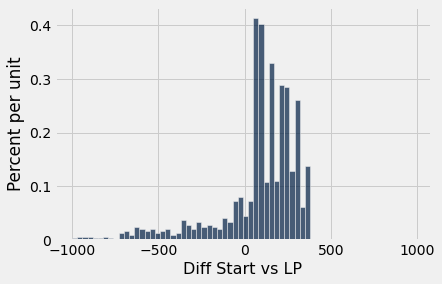

In [12]:
import math


Price = Table.read_table(path)
Price_Vol = priceTable(Price)
Chart=simulate_experiment(iterations,days,with_replacements,currenTick,tickupper,ticklower,amount0,amount1,decimals0,decimals1,dailyFee)

averageUSDC= mean(Chart.column('End Value with Fees'))
averageEth= mean(Chart.column('End Eth'))
medianDiff=median(Chart.column('LP Difference holding'))

startUSDC = Chart.column(0)[0]
startEth = Chart.column('Start Eth')[0]


print('Initial USDC: ',startUSDC)
print('Initial Eth: ',startEth)
print('Initial ETH price: ',startUSDC/startEth)

print('--------------------------------')
print('Ending Average USDC',averageUSDC)
print('Ending Average Eth',averageEth)
print('Ending Average Eth Price',averageUSDC/averageEth)
print('--------------------------------')
print('STD Diff of LP vs holding',std(Chart.column('LP Difference holding')))
print('Mean Diff of LP vs holding',mean(Chart.column('LP Difference holding')))
print('1 STD range: [',mean(Chart.column('LP Difference holding'))-std(Chart.column('LP Difference holding')),',',mean(Chart.column('LP Difference holding'))+std(Chart.column('LP Difference holding')),']')
print('Median Diff of LP vs holding',medianDiff)
print('--------------------------------')
print('Average USDC Profit:',averageUSDC - startUSDC)
print('Average Eth Profit:',averageEth - startEth)
print('--------------------------------')
Chart=Chart.with_column('Diff Start vs LP',Chart.column('End Value with Fees')-Chart.column(0))
Chart.hist('Diff Start vs LP', bins=np.arange(-1000,1000,30))


In [ ]:
'''from datascience import *
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import numpy as np


print('Mean Diff of LP vs holding',median(Chart.column('Diff Start vs LP')))
print(np.percentile(Chart.column('Diff Start vs LP'),25))

Chart.hist('Diff Start vs LP', bins=np.arange(-1000,1000,30))'''

In [ ]:
# Run Simulation of Simluation to get averages

def makeTableOfProfits(iterations):
    count = 0
    hold =[]
    Profits = Table(['Average USDC','Average ETH','median Diff','Average Profit', 'Average Eth Profit'])
    while count < iterations:
        Chart=simulate_experiment(iterations,days,with_replacements,currenTick,tickupper,ticklower,amount0,amount1,decimals0,decimals1,dailyFee)
        averageUSDC= mean(Chart.column('End Value with Fees'))
        averageEth= mean(Chart.column('End Eth'))
        medianDiff=median(Chart.column('LP Difference holding'))

        startUSDC = Chart.column(0)[0]
        startEth = Chart.column('Start Eth')[0]
        aveprofit = averageUSDC - startUSDC
        aveEthprofit = averageEth - startEth
        hold = [averageUSDC,averageEth,medianDiff,aveprofit,aveEthprofit] 
        Profits = Profits.with_row(hold)
        count +=1
    return Profits

look = makeTableOfProfits(100)

In [ ]:
look

In [ ]:
look.hist('Average ETH', bins=np.arange(7,9,.04))

In [ ]:
look.hist('Average Profit', bins=np.arange(-800,200,40))

In [ ]:
look.hist('Average Eth Profit', bins=np.arange(-.2,.2,.03))

In [ ]:
LP = Chart.column('LP Difference holding')

print('Median Fees',median(LP))
print('Average Fees',mean(LP))
Chart.hist('LP Difference holding', bins=np.arange(-4000,2000,100))


In [ ]:
print(Chart.column('Start Eth')[0])
End_eth = Chart.column('End Eth')


print('Total Value USDC Median: ',median(End_eth))
print('Total Value USDC Mean',mean(End_eth))
print('Total Value USDC STD',std(End_eth))
print('66 percent of time:',mean(End_eth)-std(End_eth),'-', mean(End_eth)+std(End_eth))


Chart.hist('End Eth', bins=np.arange(6,10,.09))

In [ ]:
End_value = Chart.column('End Value with Fees')
print('Start Value with Fees:', Chart.column('Start Value')[0])
print('Total Value USDC Median: ',median(End_value))
print('Total Value USDC Mean',mean(End_value))
print('Total Value USDC STD',std(End_value))
print('66 percent of time:',mean(End_value)-std(End_value),'-', mean(End_value)+std(End_value))

Chart.hist('End Value with Fees', bins=np.arange(7000,12000,100))

In [ ]:
# CurrentLower
#
#


a = 997
b = 1270
c = 1216.81

amount0 = 8527
amount1 = 1.6
        
ticklower = price_to_tick(1/a*10**12)
tickupper = price_to_tick(1/b*10**12)
currenTick = price_to_tick(1/c*10**12)

decimals0 = 6 
decimals1 = 18



iterations = 1000
days = 7 
with_replacements = True
dailyFee = 20

import math


Price = Table.read_table(path)
Price_Vol = priceTable(Price)
Chart=simulate_experiment(iterations,days,with_replacements,currenTick,tickupper,ticklower,amount0,amount1,decimals0,decimals1,dailyFee)

averageUSDC= mean(Chart.column('End Value with Fees'))
averageEth= mean(Chart.column('End Eth'))
medianDiff=median(Chart.column('LP Difference holding'))

startUSDC = Chart.column(0)[0]
startEth = Chart.column('Start Eth')[0]


print('Initial USDC: ',startUSDC)
print('Initial Eth: ',startEth)
print('Initial ETH price: ',startUSDC/startEth)

print('--------------------------------')
print('Ending Average USDC',averageUSDC)
print('Ending Average Eth',averageEth)
print('Ending Average Eth Price',averageUSDC/averageEth)
print('--------------------------------')
print('STD Diff of LP vs holding',std(Chart.column('LP Difference holding')))
print('Mean Diff of LP vs holding',mean(Chart.column('LP Difference holding')))
print('1 STD range: [',mean(Chart.column('LP Difference holding'))-std(Chart.column('LP Difference holding')),',',mean(Chart.column('LP Difference holding'))+std(Chart.column('LP Difference holding')),']')
print('Median Diff of LP vs holding',medianDiff)
print('--------------------------------')
print('Average USDC Profit:',averageUSDC - startUSDC)
print('Average Eth Profit:',averageEth - startEth)
print('--------------------------------')
Chart=Chart.with_column('Diff Start vs LP',Chart.column('End Value with Fees')-Chart.column(0))
Chart.hist('Diff Start vs LP', bins=np.arange(-1000,1000,30))

In [ ]:
# CurrentLower
#
#


a = 1240
b = 1350
c = 1216.81

amount0 = 0
amount1 = 8.944
        
ticklower = price_to_tick(1/a*10**12)
tickupper = price_to_tick(1/b*10**12)
currenTick = price_to_tick(1/c*10**12)

decimals0 = 6 
decimals1 = 18



iterations = 1000
days = 7 
with_replacements = True
dailyFee = 40

import math


Price = Table.read_table(path)
Price_Vol = priceTable(Price)
Chart=simulate_experiment(iterations,days,with_replacements,currenTick,tickupper,ticklower,amount0,amount1,decimals0,decimals1,dailyFee)

averageUSDC= mean(Chart.column('End Value with Fees'))
averageEth= mean(Chart.column('End Eth'))
medianDiff=median(Chart.column('LP Difference holding'))

startUSDC = Chart.column(0)[0]
startEth = Chart.column('Start Eth')[0]


print('Initial USDC: ',startUSDC)
print('Initial Eth: ',startEth)
print('Initial ETH price: ',startUSDC/startEth)

print('--------------------------------')
print('Ending Average USDC',averageUSDC)
print('Ending Average Eth',averageEth)
print('Ending Average Eth Price',averageUSDC/averageEth)
print('--------------------------------')
print('STD Diff of LP vs holding',std(Chart.column('LP Difference holding')))
print('Mean Diff of LP vs holding',mean(Chart.column('LP Difference holding')))
print('1 STD range: [',mean(Chart.column('LP Difference holding'))-std(Chart.column('LP Difference holding')),',',mean(Chart.column('LP Difference holding'))+std(Chart.column('LP Difference holding')),']')
print('Median Diff of LP vs holding',medianDiff)
print('--------------------------------')
print('Average USDC Profit:',averageUSDC - startUSDC)
print('Average Eth Profit:',averageEth - startEth)
print('--------------------------------')
Chart=Chart.with_column('Diff Start vs LP',Chart.column('End Value with Fees')-Chart.column(0))
Chart.hist('Diff Start vs LP', bins=np.arange(-1000,1000,30))